In [1]:
print("hello world")

hello world


In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import swin_t, Swin_T_Weights
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


ResNet50 gets 256*256 tensors

In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='binary'
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True
)

## 3. ResNet50 definition

In [6]:
NUMBER_OF_LABELS = 1 

model = swin_t(weights=Swin_T_Weights.DEFAULT) 
model.head = nn.Linear(model.head.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.head.parameters(): # last layer trainable
    param.requires_grad = True

## 4. Loss definition

In [7]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([401 / 1519], device=device))  
# Adjust pos_weight as needed for class imbalance according to the EDA results

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30

In [9]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc
    )
    
    scheduler.step(test_loss) 
    
    # Early stopping 
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)



Epoch number: 0


100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.2601 | Train Accuracy: 0.6297 | Train F1-score: 0.7189 | Train ROC-AUC: 0.7518 |
| Test Loss:  0.2117 | Test Accuracy:  0.7937 | Test F1-score:  0.8546 | Test ROC-AUC:  0.9050 |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 15/15 [00:46<00:00,  3.13s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.2245 | Train Accuracy: 0.7651 | Train F1-score: 0.8377 | Train ROC-AUC: 0.8390 |
| Test Loss:  0.1871 | Test Accuracy:  0.7453 | Test F1-score:  0.8120 | Test ROC-AUC:  0.9113 |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.2079 | Train Accuracy: 0.7344 | Train F1-score: 0.8091 | Train ROC-AUC: 0.8547 |
| Test Loss:  0.1693 | Test Accuracy:  0.7984 | Test F1-score:  0.8578 | Test ROC-AUC:  0.9173 |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 15/15 [00:46<00:00,  3.13s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1964 | Train Accuracy: 0.7755 | Train F1-score: 0.8440 | Train ROC-AUC: 0.8671 |
| Test Loss:  0.1638 | Test Accuracy:  0.7891 | Test F1-score:  0.8498 | Test ROC-AUC:  0.9214 |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1923 | Train Accuracy: 0.7833 | Train F1-score: 0.8501 | Train ROC-AUC: 0.8699 |
| Test Loss:  0.1624 | Test Accuracy:  0.7781 | Test F1-score:  0.8404 | Test ROC-AUC:  0.9250 |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1869 | Train Accuracy: 0.7812 | Train F1-score: 0.8487 | Train ROC-AUC: 0.8773 |
| Test Loss:  0.1531 | Test Accuracy:  0.8062 | Test F1-score:  0.8637 | Test ROC-AUC:  0.9281 |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 15/15 [00:45<00:00,  3.06s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1812 | Train Accuracy: 0.7974 | Train F1-score: 0.8604 | Train ROC-AUC: 0.8867 |
| Test Loss:  0.1512 | Test Accuracy:  0.8031 | Test F1-score:  0.8609 | Test ROC-AUC:  0.9313 |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1832 | Train Accuracy: 0.7948 | Train F1-score: 0.8594 | Train ROC-AUC: 0.8813 |
| Test Loss:  0.1501 | Test Accuracy:  0.7906 | Test F1-score:  0.8504 | Test ROC-AUC:  0.9352 |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 15/15 [00:47<00:00,  3.18s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1789 | Train Accuracy: 0.7734 | Train F1-score: 0.8405 | Train ROC-AUC: 0.8891 |
| Test Loss:  0.1430 | Test Accuracy:  0.8234 | Test F1-score:  0.8768 | Test ROC-AUC:  0.9379 |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 15/15 [00:45<00:00,  3.05s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1749 | Train Accuracy: 0.8026 | Train F1-score: 0.8648 | Train ROC-AUC: 0.8937 |
| Test Loss:  0.1413 | Test Accuracy:  0.8141 | Test F1-score:  0.8694 | Test ROC-AUC:  0.9398 |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1739 | Train Accuracy: 0.7990 | Train F1-score: 0.8615 | Train ROC-AUC: 0.8934 |
| Test Loss:  0.1404 | Test Accuracy:  0.8062 | Test F1-score:  0.8628 | Test ROC-AUC:  0.9426 |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 15/15 [00:47<00:00,  3.20s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1718 | Train Accuracy: 0.7896 | Train F1-score: 0.8531 | Train ROC-AUC: 0.8964 |
| Test Loss:  0.1354 | Test Accuracy:  0.8234 | Test F1-score:  0.8768 | Test ROC-AUC:  0.9442 |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 15/15 [00:45<00:00,  3.05s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1679 | Train Accuracy: 0.8036 | Train F1-score: 0.8651 | Train ROC-AUC: 0.9017 |
| Test Loss:  0.1352 | Test Accuracy:  0.8188 | Test F1-score:  0.8731 | Test ROC-AUC:  0.9450 |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1669 | Train Accuracy: 0.8078 | Train F1-score: 0.8687 | Train ROC-AUC: 0.9021 |
| Test Loss:  0.1381 | Test Accuracy:  0.8078 | Test F1-score:  0.8638 | Test ROC-AUC:  0.9449 |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1641 | Train Accuracy: 0.8047 | Train F1-score: 0.8646 | Train ROC-AUC: 0.9049 |
| Test Loss:  0.1291 | Test Accuracy:  0.8406 | Test F1-score:  0.8903 | Test ROC-AUC:  0.9463 |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 15/15 [00:47<00:00,  3.18s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1654 | Train Accuracy: 0.8104 | Train F1-score: 0.8708 | Train ROC-AUC: 0.9019 |
| Test Loss:  0.1364 | Test Accuracy:  0.8125 | Test F1-score:  0.8673 | Test ROC-AUC:  0.9470 |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1697 | Train Accuracy: 0.7870 | Train F1-score: 0.8513 | Train ROC-AUC: 0.8960 |
| Test Loss:  0.1283 | Test Accuracy:  0.8375 | Test F1-score:  0.8874 | Test ROC-AUC:  0.9488 |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1628 | Train Accuracy: 0.8094 | Train F1-score: 0.8687 | Train ROC-AUC: 0.9057 |
| Test Loss:  0.1345 | Test Accuracy:  0.8172 | Test F1-score:  0.8707 | Test ROC-AUC:  0.9489 |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 15/15 [00:48<00:00,  3.21s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1621 | Train Accuracy: 0.8182 | Train F1-score: 0.8765 | Train ROC-AUC: 0.9075 |
| Test Loss:  0.1305 | Test Accuracy:  0.8266 | Test F1-score:  0.8784 | Test ROC-AUC:  0.9488 |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 15/15 [00:45<00:00,  3.06s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1603 | Train Accuracy: 0.7979 | Train F1-score: 0.8591 | Train ROC-AUC: 0.9087 |
| Test Loss:  0.1296 | Test Accuracy:  0.8234 | Test F1-score:  0.8760 | Test ROC-AUC:  0.9504 |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 15/15 [00:48<00:00,  3.23s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1572 | Train Accuracy: 0.8208 | Train F1-score: 0.8780 | Train ROC-AUC: 0.9125 |
| Test Loss:  0.1294 | Test Accuracy:  0.8203 | Test F1-score:  0.8735 | Test ROC-AUC:  0.9511 |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1574 | Train Accuracy: 0.8083 | Train F1-score: 0.8674 | Train ROC-AUC: 0.9122 |
| Test Loss:  0.1299 | Test Accuracy:  0.8203 | Test F1-score:  0.8732 | Test ROC-AUC:  0.9511 |
------------------------------------------------------------------------------------------------
Early stopping à l'epoch 21


In [10]:
torch.save(model.state_dict(), '../Models/model_ft_swin_t_bc.pth')

In [11]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_swin_t_bc.csv', index=False)

## 6. Evolution of the training

In [12]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_swin_t_bc.csv')

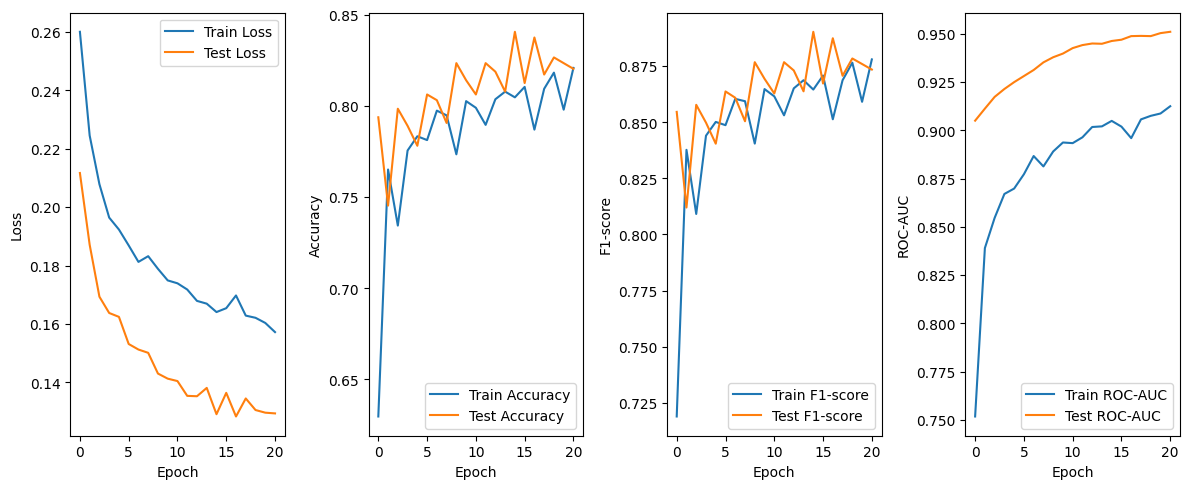

In [13]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_swin_t_bc_zoomed.png',
    title='Training Evolution - Fine Tuned Swin Binary Classification Zoomed',
    zoomed=True
)


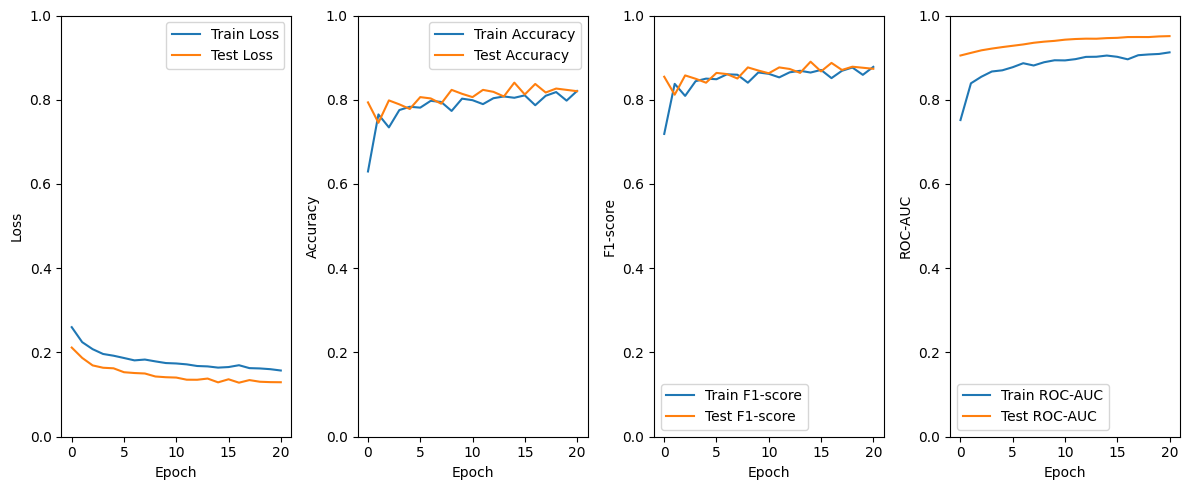

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_swin_t_bc.png',
    title='Training Evolution - Fine Tuned Swin Binary Classification',
    zoomed=False
)


## 7. Model evaluation

In [15]:
model = swin_t(weights=Swin_T_Weights.DEFAULT)
model.head = nn.Linear(model.head.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_swin_t_bc.pth', weights_only=True))

<All keys matched successfully>

In [16]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [17]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.1400 | Validation Accuracy: 0.8141 | Validation F1-score: 0.8694 | Validation ROC-AUC: 0.9341
